# Assignment 1: Text Analysis over Political Speaches

You will be working with senator speeches located in the '105-extracted-date' folder within the 'Inputs' directory. Please complete the following tasks:

i) Use cosine similarity to determine which senator's speech is closest to Senator Biden's. Describe your findings. Make sure to describe your text preprocessing and justify your choices. Validate your findings using 'sen105kh_fix.csv' and/or Wikipedia to see if the most similar speeches belong to senators from the same state and/or party. 

ii) How do your results change if you apply stemming or lemmatization? In your opinion, which is better to apply: stemming or lemmatization? Why?

iii) Create at least two visualizations to support your analysis.

iv) Use 'sen105kh_fix.csv' as the target variable for your predictions. Can you predict the 'party' of the senator from their speech? Should you use the same text preprocessing as above? Justify your choices. Probably going to use MultinomialNB() for prediction. In class, we predicted the label.

v) Write a Medium article summarizing your findings. This article should be written with a general audience in mind. The best articles may be invited for submission to CEU Economic Threads.

vi) Bonus 10 points: Read one of the articles that I have linked in this Medium post. Contrast your findings in i) with theirs and discuss any discrepancies. What are possible solutions?

## Things I need to do to this assignment

- Simplify code
- Remove stopwords


In [1]:
import os
import time
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
import nltk
import matplotlib as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# i) Use cosine similarity to determine which senator's speech is closest to Senator Biden's. Describe your findings. Make sure to describe your text preprocessing and justify your choices. Validate your findings using **'sen105kh_fix.csv'** and/or Wikipedia to see if the most similar speeches belong to senators from the same state and/or party. 

In [5]:
# function to read the speaches
def read_speech(file_path):
    with open(file_path, 'r') as file:
        return file.read()


# Path to the directory containing the speeches
speeches_dir = 'C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/105-extracted-date'

# Dictionary to hold senator name and their speech
senator_speeches = {}

for file_name in os.listdir(speeches_dir):
    if file_name.endswith('.txt'):
        # Extract senator name from file name or another way you have structured it
        senator_name = file_name.replace('.txt', '')
        file_path = os.path.join(speeches_dir, file_name)
        senator_speeches[senator_name] = read_speech(file_path)

# Just to check the first 5 senator names
list(senator_speeches.keys())[:5]


['105-abraham-mi',
 '105-akaka-hi',
 '105-allard-co',
 '105-ashcroft-mo',
 '105-baucus-mt']

In [6]:
# Function to preprocess text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation/numbers and tokenize
    tokens = [word for word in text.split() if word.isalpha() and word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

# preprocessing all speeches
processed_speeches = {senator: preprocess_text(speech) for senator, speech in senator_speeches.items()}

# convert to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_speeches.values())

# setting biden's speach to `biden_index` for consine similarity comparison
biden_index = list(processed_speeches.keys()).index('105-biden-de') 


In [7]:
# calculate the cosine similarity to biden's speech
cosine_similarities = cosine_similarity(tfidf_matrix[biden_index], tfidf_matrix).flatten()

# creating a dictionary to hold the similarity scores
similarity_scores = {senator: score for senator, score in zip(processed_speeches.keys(), cosine_similarities)}

# Sort the senators by similarity score
sorted_similarities = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)

# Display the top 5 most similar speeches to Biden's
for senator, score in sorted_similarities[1:6]:  # Skipping the first one because it's Biden's
    print(f"{senator}: {score:.4f}")


105-kerry-ma: 0.7925
105-kyl-az: 0.7845
105-hutchison-tx: 0.7822
105-lieberman-ct: 0.7813
105-roberts-ks: 0.7767


In [5]:
import pandas as pd

# Define the path to the CSV file
csv_path = "C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/sen105kh_fix.csv"

# Load the CSV for validation, using ';' as the separator since that's what your file is using.
senators_info = pd.read_csv(csv_path, sep=';')

# Let's check the DataFrame to ensure it's loaded correctly
print(senators_info.head())


   cong      lname stateab   lstate     id  dist  party
0   105   sessions      al  ALABAMA  49700     0    200
1   105     shelby      al  ALABAMA  94659     0    200
2   105  murkowski      ak  ALASKA   14907     0    200
3   105    stevens      ak  ALASKA   12109     0    200
4   105        kyl      az  ARIZONA  15429     0    200


In [6]:
# Load the CSV for validation, using ';' as the separator
senators_info = pd.read_csv(csv_path, sep=';')
senators_info.columns = ['cong', 'name', 'state_abbr', 'state', 'id', 'dist', 'party']
top_5_senators = ['kerry-ma', 'kyl-az', 'hutchison-tx', 'lieberman-ct', 'roberts-ks']

# Let's find Biden's party and state for reference
biden_info = senators_info[senators_info['name'].str.contains('biden')]
biden_party = biden_info['party'].iloc[0]
biden_state_abbr = biden_info['state_abbr'].iloc[0]

print(f"Biden's party: {biden_party}")
print(f"Biden's state abbreviation: {biden_state_abbr}")

# Now let's extract the information for the top 5 senators
for senator in top_5_senators:
    # Each senator string is formatted as 'last_name-state_abbr'
    senator_last_name, senator_state_abbr = senator.split('-')
    
    # Look up this senator in the senators_info DataFrame
    senator_info = senators_info[
        (senators_info['name'].str.lower().str.contains(senator_last_name)) & 
        (senators_info['state_abbr'].str.lower() == senator_state_abbr.lower())
    ]
    
    if not senator_info.empty:
        senator_party = senator_info['party'].iloc[0]
        print(f"Senator {senator} is from {senator_state_abbr.upper()} and belongs to party {senator_party}")
        print(f"Commonality with Biden - State: {'Yes' if senator_state_abbr.lower() == biden_state_abbr.lower() else 'No'}, Party: {'Yes' if senator_party == biden_party else 'No'}")
    else:
        print(f"No information found for Senator {senator}")


Biden's party: 100
Biden's state abbreviation: de
Senator kerry-ma is from MA and belongs to party 100
Commonality with Biden - State: No, Party: Yes
Senator kyl-az is from AZ and belongs to party 200
Commonality with Biden - State: No, Party: No
Senator hutchison-tx is from TX and belongs to party 200
Commonality with Biden - State: No, Party: No
Senator lieberman-ct is from CT and belongs to party 100
Commonality with Biden - State: No, Party: Yes
Senator roberts-ks is from KS and belongs to party 200
Commonality with Biden - State: No, Party: No


# ii) How do your results change if you apply stemming or lemmatization? In your opinion, which is better to apply: stemming or lemmatization? Why?


In [7]:
# Initialize stemmer and lemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocess_text(text, use_stemming=False):
    """Preprocess the text and apply stemming or lemmatization."""
    tokens = word_tokenize(text.lower())
    if use_stemming:
        tokens = [ps.stem(token) for token in tokens]
    else:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

def read_speech(file_path):
    """Reads a speech from a file."""
    with open(file_path, 'r') as file:
        return file.read()

def find_top_similar_speeches(tfidf_matrix, biden_index, filenames, senators_info):
    cosine_similarities = cosine_similarity(tfidf_matrix[biden_index:biden_index+1], tfidf_matrix).flatten()
    top_indices = cosine_similarities.argsort()[-6:][::-1][1:]  # Skip Biden's own speech
    top_speeches_info = []

    for index in top_indices:
        # Extracting senator's name from filename, adjust this according to your filenames
        filename_without_ext = filenames[index].replace('.txt', '')
        senator_name_extracted = filename_without_ext.split('-')[1]  # Assuming format '105-lastname-state'
        # Match extracted name with senators_info 'name' column
        senator_row = senators_info[senators_info['name'].str.contains(senator_name_extracted, case=False)].iloc[0]
        top_speeches_info.append({
            'Senator': senator_row['name'],
            'Party': senator_row['party'],
            'Similarity': cosine_similarities[index]
        })

    return top_speeches_info


In [9]:
# Directory containing the speeches
speeches_dir = 'C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/105-extracted-date'
speeches = {}
start_time = time.time()

for file_name in os.listdir(speeches_dir):
    if file_name.endswith('.txt'):
        file_path = os.path.join(speeches_dir, file_name)
        speeches[file_name] = read_speech(file_path)

print(f"Read {len(speeches)} speeches. Time taken: {time.time() - start_time:.2f}s")


Read 100 speeches. Time taken: 0.43s


In [10]:
# Preprocess and vectorize speeches
tfidf_vectorizer = TfidfVectorizer()
start_time = time.time()
preprocessed_speeches_stem = [preprocess_text(speech, use_stemming=True) for speech in speeches.values()]
print(f"Stemming completed. Time taken: {time.time() - start_time:.2f}s")


Stemming completed. Time taken: 410.92s


In [11]:
start_time = time.time()
preprocessed_speeches_lemmatize = [preprocess_text(speech, use_stemming=False) for speech in speeches.values()]
print(f"Lemmatization completed. Time taken: {time.time() - start_time:.2f}s")


Lemmatization completed. Time taken: 211.90s


In [12]:
# Vectorize the speeches
start_time = time.time()
tfidf_matrix_stem = tfidf_vectorizer.fit_transform(preprocessed_speeches_stem)
print(f"TF-IDF vectorization (stemming) completed. Time taken: {time.time() - start_time:.2f}s")


TF-IDF vectorization (stemming) completed. Time taken: 11.99s


In [13]:
start_time = time.time()
tfidf_matrix_lemmatize = tfidf_vectorizer.fit_transform(preprocessed_speeches_lemmatize)
print(f"TF-IDF vectorization (lemmatization) completed. Time taken: {time.time() - start_time:.2f}s")


TF-IDF vectorization (lemmatization) completed. Time taken: 11.88s


In [14]:
# Assuming Biden's speech is among these
biden_index = list(speeches.keys()).index('105-biden-de.txt')


In [15]:
# Define the path to the CSV file
metadata_df = "C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/sen105kh_fix.csv"

# Load the CSV for validation, using ';' as the separator since that's what your file is using.
senators_info = pd.read_csv(metadata_df, sep=';')

# Let's check the DataFrame to ensure it's loaded correctly
print(senators_info.head())

# Load the CSV for validation, using ';' as the separator
senators_info = pd.read_csv(metadata_df, sep=';')
senators_info.columns = ['cong', 'name', 'state_abbr', 'state', 'id', 'dist', 'party']


   cong      lname stateab   lstate     id  dist  party
0   105   sessions      al  ALABAMA  49700     0    200
1   105     shelby      al  ALABAMA  94659     0    200
2   105  murkowski      ak  ALASKA   14907     0    200
3   105    stevens      ak  ALASKA   12109     0    200
4   105        kyl      az  ARIZONA  15429     0    200


In [16]:
filenames = list(speeches.keys())

top_speeches_info_stem = find_top_similar_speeches(tfidf_matrix_stem, biden_index, list(speeches.keys()), senators_info)
df_stem = pd.DataFrame(top_speeches_info_stem)

print("Top 5 similar speeches to Biden's (Stemming):")
print(df_stem)

top_speeches_info_lemmatize = find_top_similar_speeches(tfidf_matrix_lemmatize, biden_index, list(speeches.keys()), senators_info)
df_lemmatize = pd.DataFrame(top_speeches_info_lemmatize)

print("\nTop 5 similar speeches to Biden's (Lemmatization):")
print(df_lemmatize)



Top 5 similar speeches to Biden's (Stemming):
     Senator  Party  Similarity
0      craig    200    0.983739
1      glenn    100    0.983167
2  lieberman    100    0.982702
3     kerrey    100    0.982466
4   ashcroft    200    0.982031

Top 5 similar speeches to Biden's (Lemmatization):
     Senator  Party  Similarity
0      kerry    100    0.983961
1      craig    200    0.983795
2      glenn    100    0.983350
3  lieberman    100    0.982831
4   ashcroft    200    0.982171


# iii) Create at least two visualizations to support your analysis.

In [39]:
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


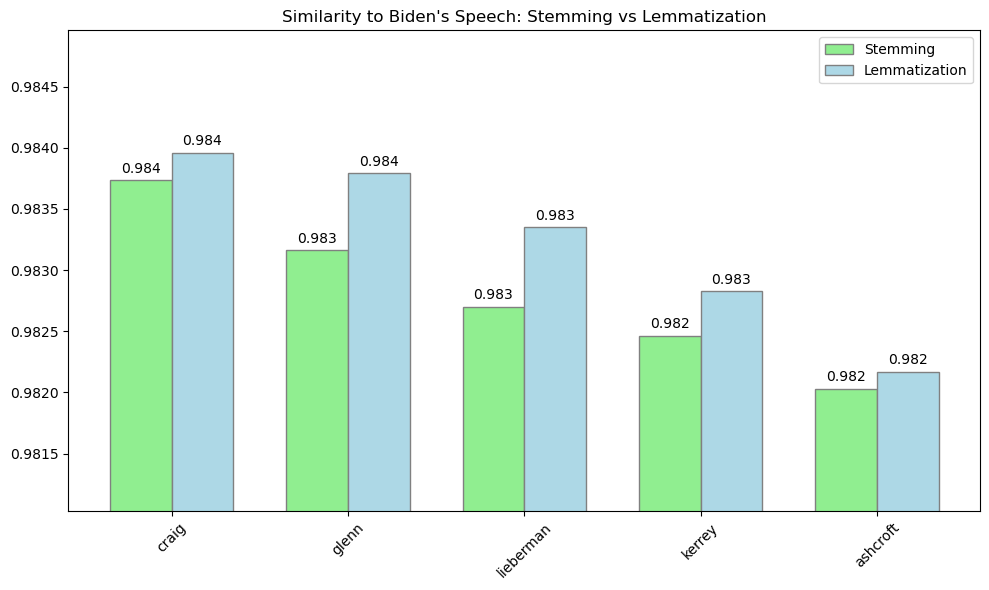

In [40]:
import matplotlib.pyplot as plt

# Visualization 1: Comparing Stemming and Lemmatization results with a tighter y-axis
fig, ax = plt.subplots(figsize=(10, 6))
# Set position of bar on X axis
bar_width = 0.35
r1 = range(len(df_stem))
r2 = [x + bar_width for x in r1]

# Make the plot
stem_bars = ax.bar(r1, df_stem['Similarity'], color='lightgreen', width=bar_width, edgecolor='grey', label='Stemming')
lemmatize_bars = ax.bar(r2, df_lemmatize['Similarity'], color='lightblue', width=bar_width, edgecolor='grey', label='Lemmatization')

# Add xticks on the middle of the group bars
ax.set_xlabel('')
ax.set_xticks([r + bar_width/2 for r in range(len(df_stem))])
ax.set_xticklabels(df_stem['Senator'])
ax.set_ylabel('')
ax.set_title('Similarity to Biden\'s Speech: Stemming vs Lemmatization')
ax.legend()

# Set y-axis limit to zoom in on the differences
min_similarity = min(df_stem['Similarity'].min(), df_lemmatize['Similarity'].min())
max_similarity = max(df_stem['Similarity'].max(), df_lemmatize['Similarity'].max())
ax.set_ylim([min_similarity - 0.001, max_similarity + 0.001])  # Adjust buffer as needed

# Create labels for the similarities
add_labels(stem_bars)
add_labels(lemmatize_bars)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# establishing biden's information, party, and state for comparison
biden_info = senators_info[senators_info['name'].str.contains('biden')].iloc[0]
biden_party = biden_info['party']
biden_state = biden_info['state_abbr']


In [19]:
def assign_colors(row, biden_party, biden_state):
    if row['Party'] == biden_party and row['State'] == biden_state:
        return 'green'  # same party and state as Biden
    elif row['Party'] == biden_party:
        return 'blue'   # same party as Biden
    elif row['State'] == biden_state:
        return 'cyan'   # same state as Biden
    else:
        return 'red'    # party nor state matches Biden


In [20]:
df_stem['State'] = df_stem['Senator'].apply(lambda name: senators_info[senators_info['name'].str.contains(name, case=False)]['state_abbr'].iloc[0])
df_lemmatize['State'] = df_lemmatize['Senator'].apply(lambda name: senators_info[senators_info['name'].str.contains(name, case=False)]['state_abbr'].iloc[0])


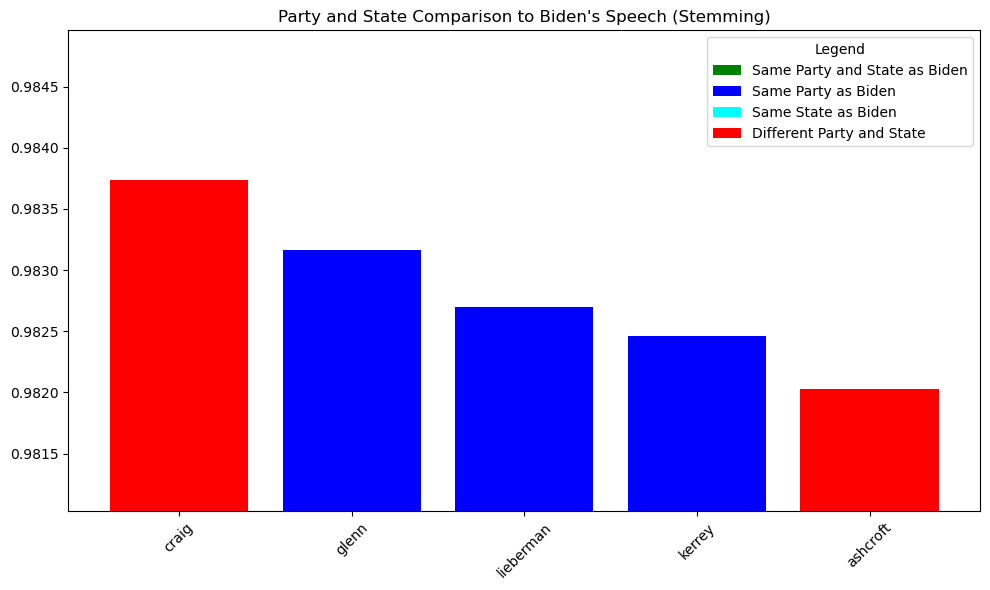

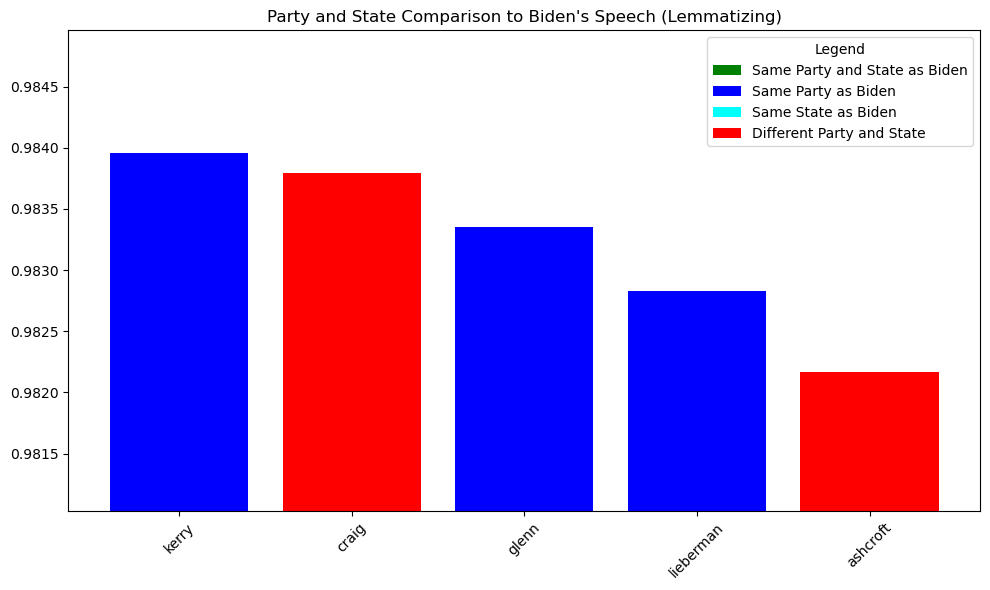

In [41]:
from matplotlib.patches import Patch

# visualizing Stemming with party and state comparison
plt.figure(figsize=(10, 6))
df_stem['Color'] = df_stem.apply(lambda row: assign_colors(row, biden_party, biden_state), axis=1)
stem_bars = plt.bar(df_stem['Senator'], df_stem['Similarity'], color=df_stem['Color'])
plt.xlabel('')
plt.ylabel('')
plt.title('Party and State Comparison to Biden\'s Speech (Stemming)')
plt.ylim([min_similarity - 0.001, max_similarity + 0.001])

# creating and adding legend
legend_elements = [Patch(facecolor='green', label='Same Party and State as Biden'),
                   Patch(facecolor='blue', label='Same Party as Biden'),
                   Patch(facecolor='cyan', label='Same State as Biden'),
                   Patch(facecolor='red', label='Different Party and State')]
plt.legend(handles=legend_elements, title='Legend')

# rating x-axis labels and adjusting layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##################################################################################################################

# visualizing lemmatizing with party and state comparison
plt.figure(figsize=(10, 6))
df_lemmatize['Color'] = df_lemmatize.apply(lambda row: assign_colors(row, biden_party, biden_state), axis=1)
stem_bars = plt.bar(df_lemmatize['Senator'], df_lemmatize['Similarity'], color=df_lemmatize['Color'])
plt.xlabel('')
plt.ylabel('')
plt.title('Party and State Comparison to Biden\'s Speech (Lemmatizing)')
plt.ylim([min_similarity - 0.001, max_similarity + 0.001])

# creating and adding legend
legend_elements = [Patch(facecolor='green', label='Same Party and State as Biden'),
                   Patch(facecolor='blue', label='Same Party as Biden'),
                   Patch(facecolor='cyan', label='Same State as Biden'),
                   Patch(facecolor='red', label='Different Party and State')]
plt.legend(handles=legend_elements, title='Legend')

# rotating x-axis labels and adjusting layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# iv) Use 'sen105kh_fix.csv' as the target variable for your predictions. Can you predict the party of the senator from their speech? Should you use the same text preprocessing as above? Justify your choices.

In [35]:
X = tfidf_matrix_lemmatize

y = senators_info["party"]

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)


MultinomialNB()

In [38]:
from sklearn.metrics import accuracy_score, classification_report

# Predict the party for the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.55
              precision    recall  f1-score   support

         100       0.00      0.00      0.00         9
         200       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
